In [2]:
import tensorflow as tf

# Charger les datasets
train_dir = "/kaggle/input/data-signe-language/datasett/train"
val_dir = "/kaggle/input/dataset-val/test_set"
test_dir = "/kaggle/input/data-signe-language/datasett/test"

batch_size = 32
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Normalisation des images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 69659 files belonging to 29 classes.
Found 1029 files belonging to 29 classes.
Found 17400 files belonging to 29 classes.


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Charger MobileNetV2 pré-entraîné avec les poids locaux
weights_path = '/kaggle/input/file-data/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=weights_path)

# Geler les couches de base
base_model.trainable = False

# Ajouter un classifieur avec régularisation
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Ajout de L2
    layers.Dropout(0.5),
    layers.Dense(29, activation='softmax')  # 29 catégories
])

# Compiler le modèle avec un taux d'apprentissage réduit
model.compile(optimizer=Adam(learning_rate=0.0001),  # Taux d'apprentissage réduit
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Augmentation des données pour améliorer la robustesse
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalisation des pixels
    rotation_range=20,             # Rotation aléatoire
    width_shift_range=0.2,         # Translation horizontale
    height_shift_range=0.2,        # Translation verticale
    shear_range=0.2,               # Cisaillement
    zoom_range=0.2,                # Zoom
    horizontal_flip=True,          # Flip horizontal
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation uniquement pour la validation

# Charger les données d'entraînement et de validation
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,  # Chemin d'entraînement
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_dataset = val_datagen.flow_from_directory(
    directory=val_dir,  # Chemin de validation
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Callback pour Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraîner le modèle avec Early Stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

# Fine-tuning : dé-geler les dernières couches de MobileNetV2 après le pré-entraînement
base_model.trainable = True

# Compiler à nouveau avec un taux d'apprentissage encore plus faible
model.compile(optimizer=Adam(learning_rate=0.00001),  # Réduction supplémentaire du taux d'apprentissage
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Ré-entraînement avec les couches dé-gelées
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Nombre d'époques réduit pour éviter le surapprentissage
    callbacks=[early_stopping]
)


Found 69659 images belonging to 29 classes.
Found 1029 images belonging to 29 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2177/2177 ━━━━━━━━━━━━━━━━━━━━ 967s 438ms/step - accuracy: 0.3696 - loss: 5.3029 - val_accuracy: 0.2206 - val_loss: 4.0337
Epoch 2/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 715s 327ms/step - accuracy: 0.7398 - loss: 2.0358 - val_accuracy: 0.2352 - val_loss: 3.5103
Epoch 3/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 714s 327ms/step - accuracy: 0.7921 - loss: 1.3700 - val_accuracy: 0.2167 - val_loss: 3.3504
Epoch 4/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 708s 324ms/step - accuracy: 0.8131 - loss: 1.1063 - val_accuracy: 0.2352 - val_loss: 3.2953
Epoch 5/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 710s 325ms/step - accuracy: 0.8245 - loss: 0.9727 - val_accuracy: 0.2235 - val_loss: 3.3198
Epoch 6/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 718s 329ms/step - accuracy: 0.8333 - loss: 0.9007 - val_accuracy: 0.2293 - val_loss: 3.2744
Epoch 7/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 716s 328ms/step - accuracy: 0.8370 - loss: 0.8550 - val_accuracy: 0.2225 - val_loss: 3.4406
Epoch 8/20
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 713s 326ms/step - accuracy: 0.8

In [4]:
# Évaluation sur le test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.9705 - loss: 0.3363
Test Accuracy: 0.97


In [5]:
model.save("signe_language_model_mobilNetV2.h5")

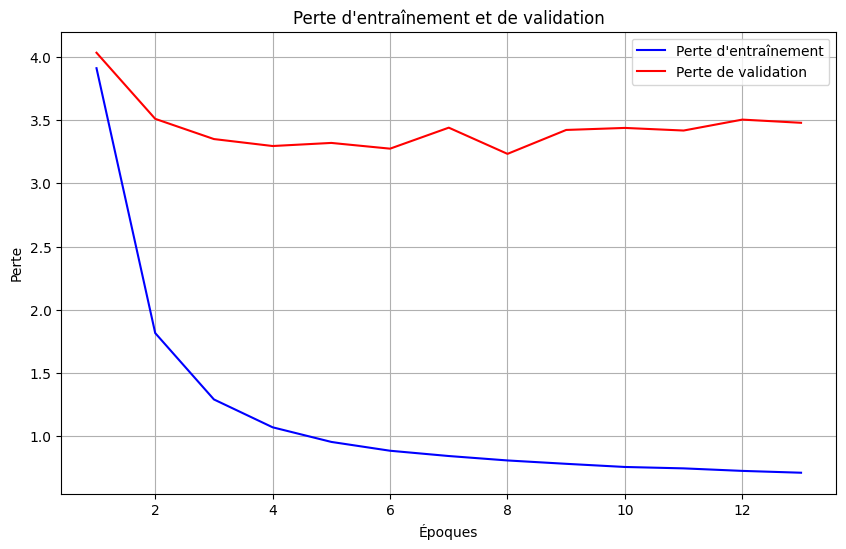

In [6]:
import matplotlib.pyplot as plt

# Récupérer l'historique de perte et de précision
history_dict = history.history

# Récupérer les pertes
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Générer les époques
epochs = range(1, len(loss) + 1)

# Tracer la perte
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'r-', label='Perte de validation')
plt.title('Perte d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid()
plt.show()

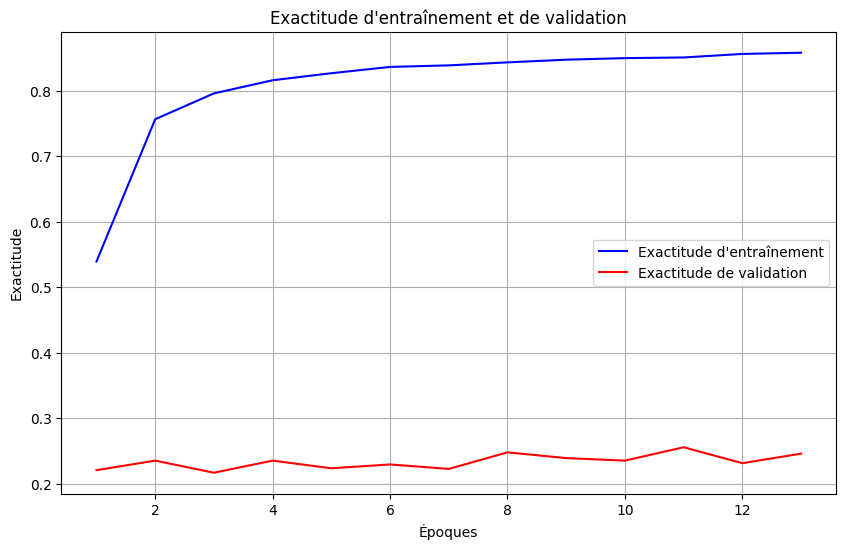

In [7]:
# Récupérer l'exactitude
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Tracer l'exactitude
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'b-', label='Exactitude d\'entraînement')
plt.plot(epochs, val_accuracy, 'r-', label='Exactitude de validation')
plt.title('Exactitude d\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()
plt.grid()
plt.show()


In [8]:
# Dernières valeurs
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]
final_train_accuracy = accuracy[-1]
final_val_accuracy = val_accuracy[-1]

print(f"Perte finale d'entraînement : {final_train_loss:.4f}")
print(f"Perte finale de validation : {final_val_loss:.4f}")
print(f"Exactitude finale d'entraînement : {final_train_accuracy:.4%}")
print(f"Exactitude finale de validation : {final_val_accuracy:.4%}")

Perte finale d'entraînement : 0.7096
Perte finale de validation : 3.4791
Exactitude finale d'entraînement : 85.8109%
Exactitude finale de validation : 24.5870%


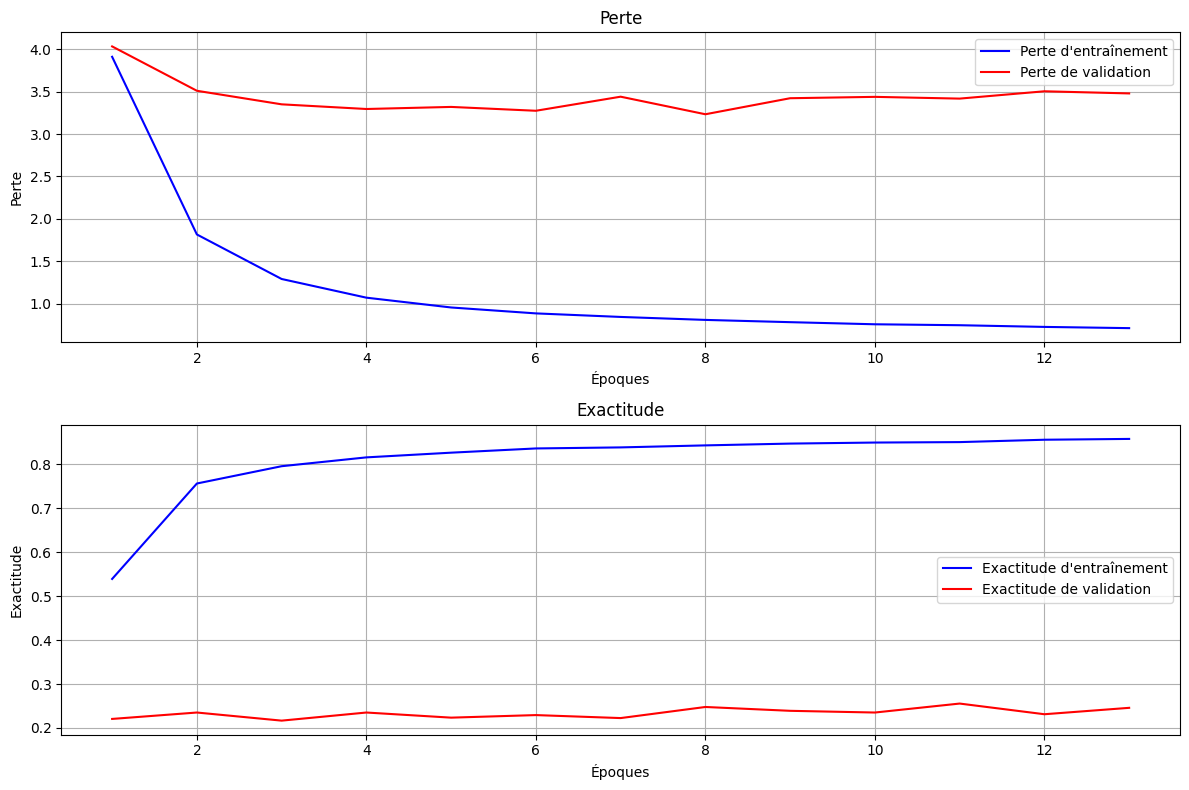

In [9]:
plt.figure(figsize=(12, 8))

# Perte
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'b-', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'r-', label='Perte de validation')
plt.title('Perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.grid()

# Exactitude
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy, 'b-', label='Exactitude d\'entraînement')
plt.plot(epochs, val_accuracy, 'r-', label='Exactitude de validation')
plt.title('Exactitude')
plt.xlabel('Époques')
plt.ylabel('Exactitude')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
